# MODULES

In [1]:
import numpy as np
import os
import struct
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# DATA IN/OUTPUT

In [2]:
def read(img, lbl):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    fname_img = os.path.join(os.getcwd(), img)
    fname_lbl = os.path.join(os.getcwd(), lbl)

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

#     get_img = lambda idx: (lbl[idx], img[idx])

#     # Create an iterator which returns each image in turn
#     for i in range(len(lbl)):
#         yield get_img(i)
    return lbl, img

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    %matplotlib inline
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()


In [3]:
lbl, img = read('train-images.idx3-ubyte','train-labels-idx1-ubyte' )
print(lbl.shape, img.shape)

(60000,) (60000, 28, 28)


In [4]:
class SVM():
    def __init__(self, eta=0.01, C=100.0, max_iter=50, batch_size=100, random_state = None, test = False):
        self.eta = eta
        self.C = C
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.test = test
        self.random_state = random_state
        self.avg_cost = []
        
    def fit(self, X, Y):
        '''
        X : (n_samples, n_features) 
        Y : (n_samples,), {1, -1}
        '''
    
        n_samples = X.shape[0] # 60000
        n_features = X.shape[1] # 784
        n_batch = int(n_samples/self.batch_size)
        avg_cost = 0
        
        for r in range(n_batch):
            # w = w - (eta * -tY) + 람다 * w
            # b = b - ( eta * -t )
            dw = np.zeros((self.batch_size,n_features))
            db = np.zeros((self.batch_size))
            
            X_batch = X[r * self.batch_size:(r+1) * self.batch_size]
            Y_batch = Y[r * self.batch_size:(r+1) * self.batch_size]
            
            
            cost = self.hinge_loss(Y_batch,X_batch)
            dw[cost > 0] = (-1) * X_batch[cost > 0] * np.reshape(Y_batch[cost > 0],(Y_batch[cost > 0].shape[0],1)) + self.w / self.C
            dw[cost == 0] = self.w / self.C
            db[cost > 0] = (-1) * Y_batch[cost > 0]
            self.w = self.w - ( self.eta * np.mean(dw,axis=0) )
            self.b = self.b - ( self.eta * np.mean(db) )
            
            avg_cost += np.sum(cost)

        avg_cost /= n_batch
        self.avg_cost.append(avg_cost)
                


    def classfy(self, Xi):
        '''
        Xi : ((i+j),784)
        return : (i+j,)
        '''
        return np.matmul(Xi, self.w) + self.b
    def hinge_loss(self, t, X):
        '''
        t : {-1,1}, (i+j,) answer labels.
        X : ((i+j),784) features.
        
        return : (i+j,)
        '''
        X = 1 - (self.classfy(X) * t)
        X[X <= 0] = 0
        return X
    def OvO(self, X, Y): # 45개.
        ################
        '''
        X : (n_samples, 28, 28)
        Y : (n_samples)
        '''
        X = np.reshape(X,(X.shape[0], X.shape[1] * X.shape[1]))
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        labels = np.unique(Y)
        n_labels = labels.shape[0]
        
        
        ################
        self.OvO_classfiers = np.zeros((n_labels,n_labels , n_features)) # 하드코딩.
            
        for (i,j) in itertools.combinations(labels, 2): #10 comb 2.
            
            self.initialize_weights(n_features = n_features)
            print("fitting", "(",i,",",j,")...")
            X_i, Y_i = X[Y==i], Y[Y==i]
            X_j, Y_j = X[Y==j], Y[Y==j]
            Y_i[:], Y_j[:] = 1, -1
            X_ij = np.append(X_i,X_j, axis=0) # axis. 784.
            Y_ij = np.append(Y_i,Y_j, axis=0)
                
            for iter in range(self.max_iter):
                X_shuffle, Y_shuffle = self.shuffle(X_ij, Y_ij)
                self.fit(X_shuffle, Y_shuffle)
            self.OvO_classfiers[i,j] = self.w
            self.avg_cost_plt()
                
    
    def voting(self, X, i, j):
        '''
        X : n_samples,n_features
        Y : n_samples.
        '''
        return np.where(np.dot(X, self.OvO_classfiers[i, j]) >= 0 , 1, -1)
    def shuffle(self, X, Y):
        temp = np.copy(X)
        random_idx = np.arange(X.shape[0])
        np.random.shuffle(random_idx)
        return X[random_idx], Y[random_idx]
    def initialize_weights(self, n_features):
        self.rgen = np.random.RandomState(self.random_state)
        self.w = self.rgen.normal(loc=0.0, scale=0.01, size=n_features)
        self.b = self.rgen.normal(loc=0.0, scale=0.01, size=1)
    def avg_cost_plt(self):
        plt.plot(range(1, len(self.avg_cost) + 1), self.avg_cost, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Average Cost')
        self.avg_cost = []
        plt.tight_layout()
        # plt.savefig('images/02_15_2.png', dpi=300)
        plt.show()
        

In [5]:
test = SVM()

In [11]:

a = img[lbl==3]
b = lbl[lbl==3]
b[:] = 1
c = img[lbl==7]
d = lbl[lbl==7]
d[:] = -1
img_re = np.append(a,c,axis=0)
lbl_re = np.append(b,d,axis=0)
img_re, lbl_re = test.shuffle(img_re, lbl_re)

fitting ( 0 , 1 )...


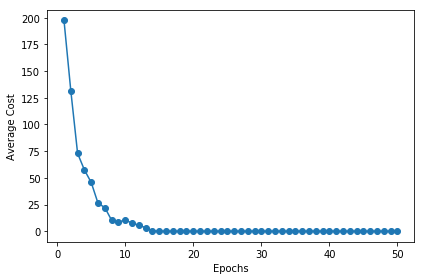

fitting ( 0 , 2 )...


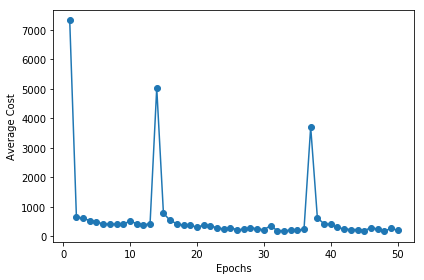

fitting ( 0 , 3 )...


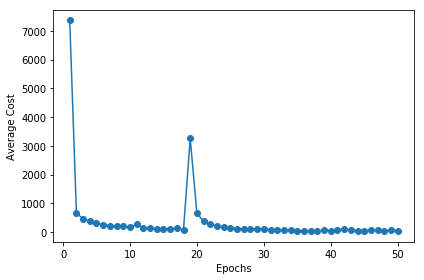

fitting ( 0 , 4 )...


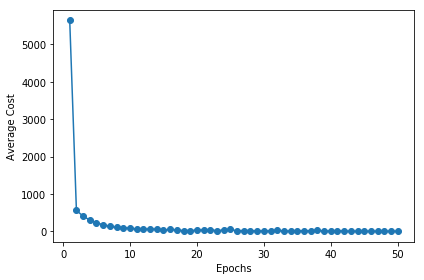

fitting ( 0 , 5 )...


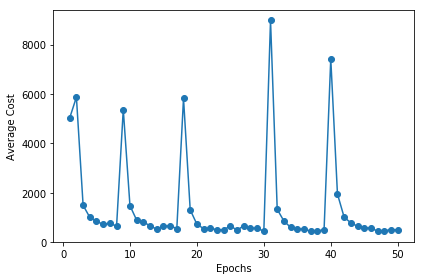

fitting ( 0 , 6 )...


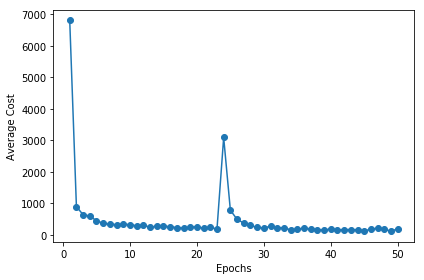

fitting ( 0 , 7 )...


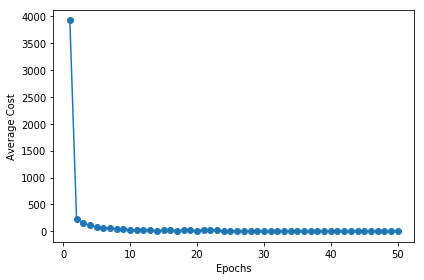

fitting ( 0 , 8 )...


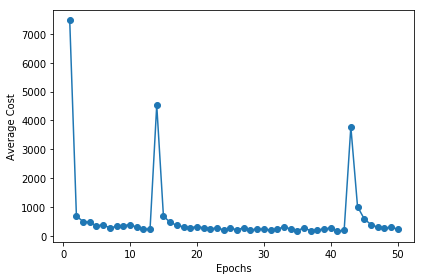

fitting ( 0 , 9 )...


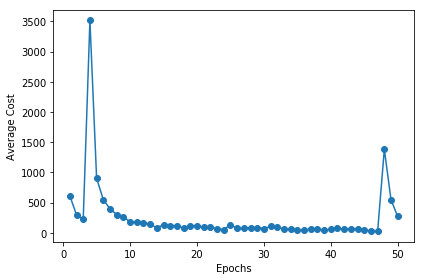

fitting ( 1 , 2 )...


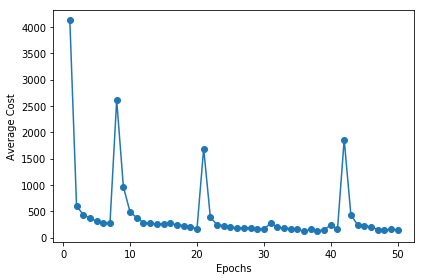

fitting ( 1 , 3 )...


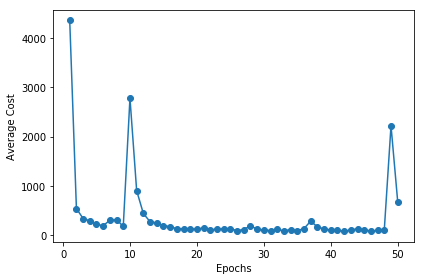

fitting ( 1 , 4 )...


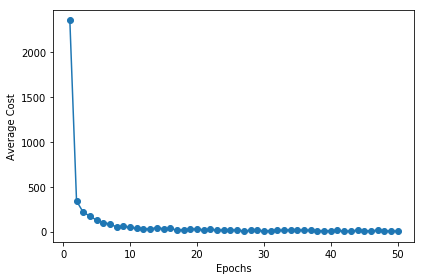

fitting ( 1 , 5 )...


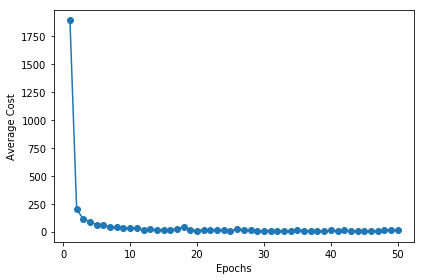

fitting ( 1 , 6 )...


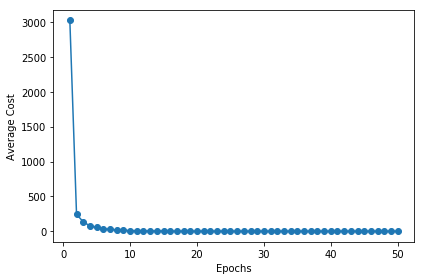

fitting ( 1 , 7 )...


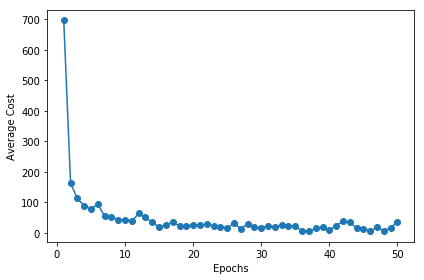

fitting ( 1 , 8 )...


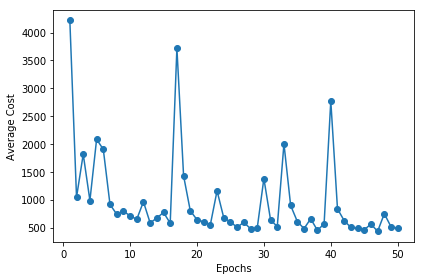

fitting ( 1 , 9 )...


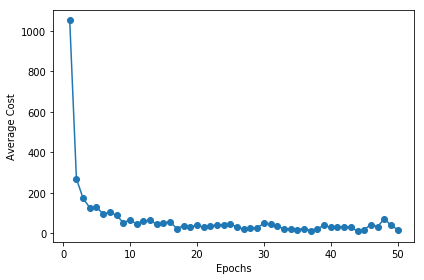

fitting ( 2 , 3 )...


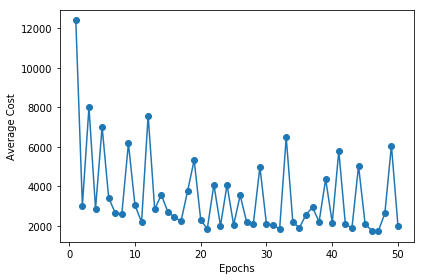

fitting ( 2 , 4 )...


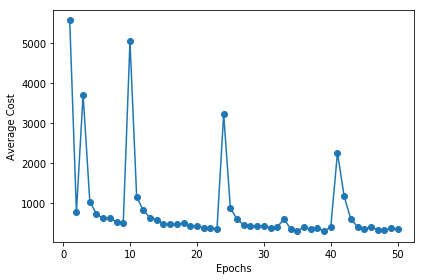

fitting ( 2 , 5 )...


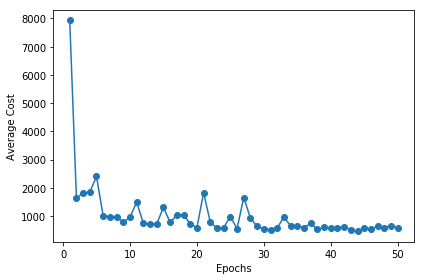

fitting ( 2 , 6 )...


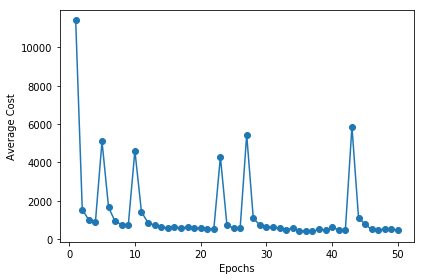

fitting ( 2 , 7 )...


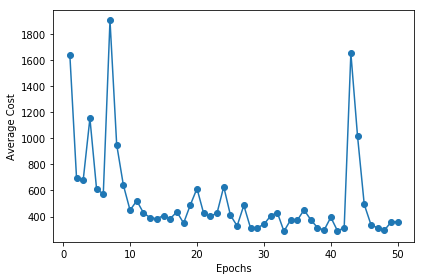

fitting ( 2 , 8 )...


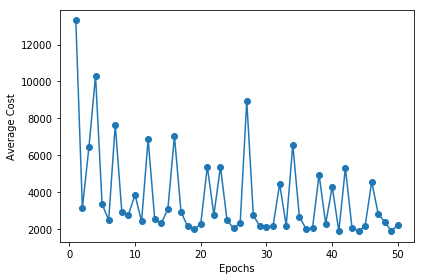

fitting ( 2 , 9 )...


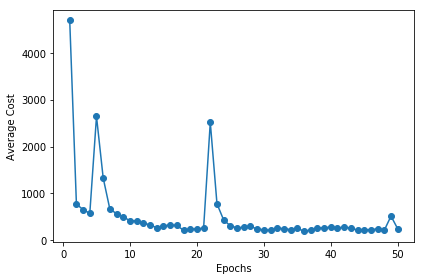

fitting ( 3 , 4 )...


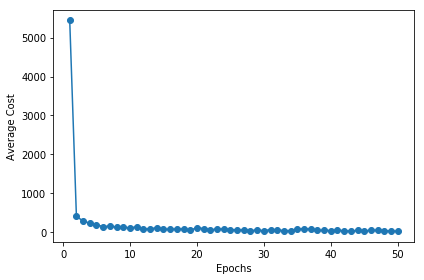

fitting ( 3 , 5 )...


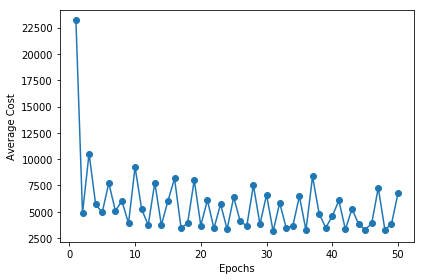

fitting ( 3 , 6 )...


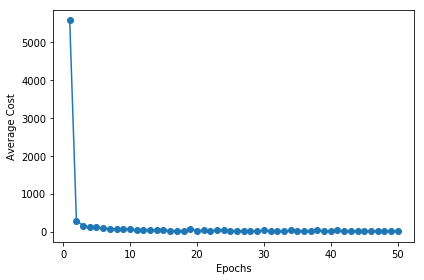

fitting ( 3 , 7 )...


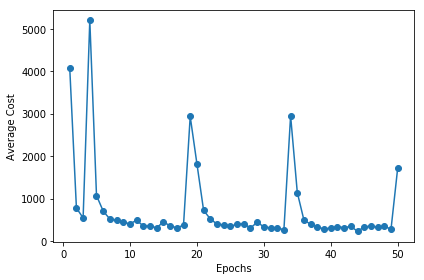

fitting ( 3 , 8 )...


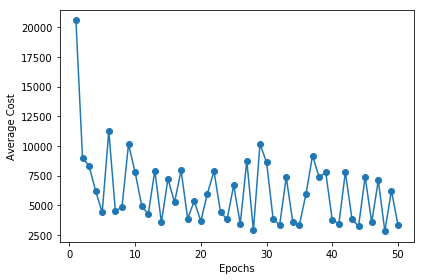

fitting ( 3 , 9 )...


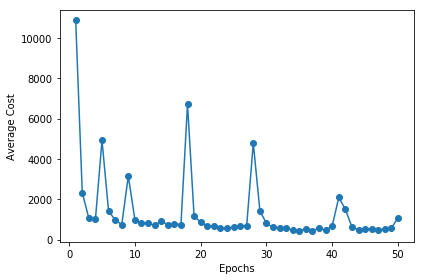

fitting ( 4 , 5 )...


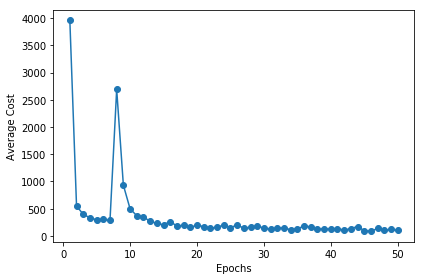

fitting ( 4 , 6 )...


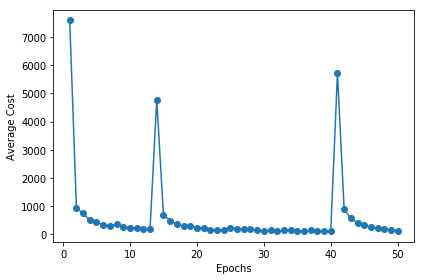

fitting ( 4 , 7 )...


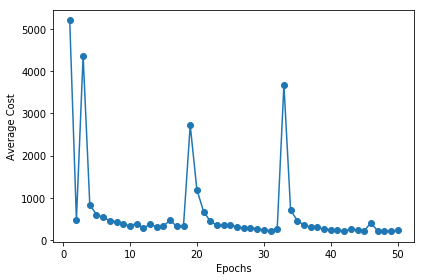

fitting ( 4 , 8 )...


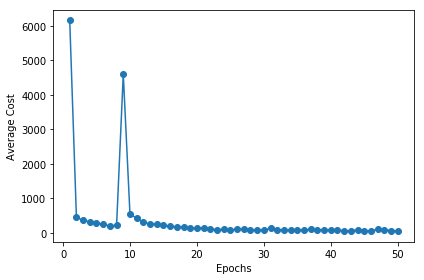

fitting ( 4 , 9 )...


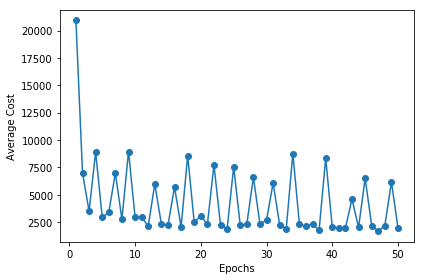

fitting ( 5 , 6 )...


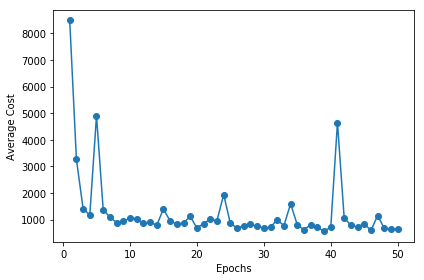

fitting ( 5 , 7 )...


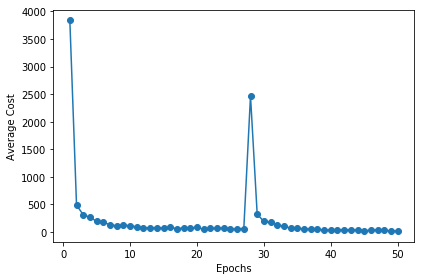

fitting ( 5 , 8 )...


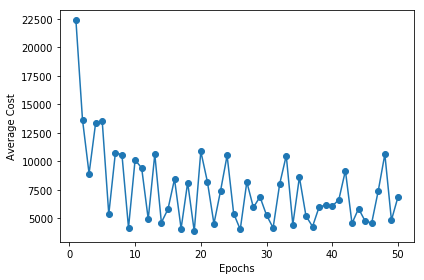

fitting ( 5 , 9 )...


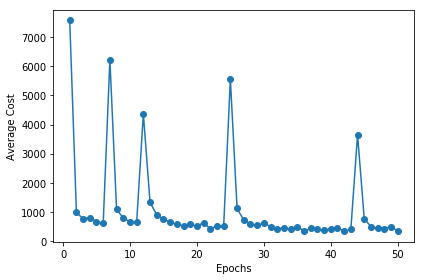

fitting ( 6 , 7 )...


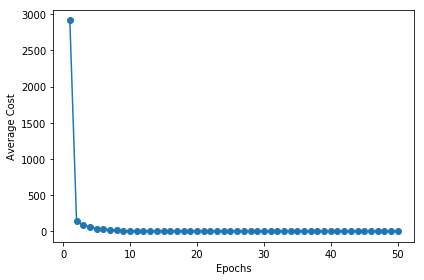

fitting ( 6 , 8 )...


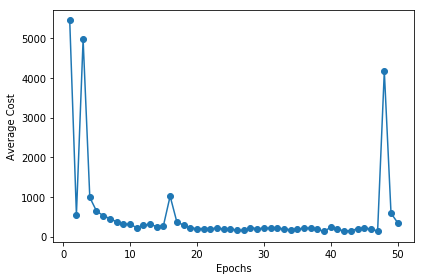

fitting ( 6 , 9 )...


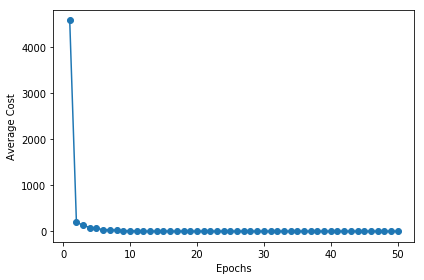

fitting ( 7 , 8 )...


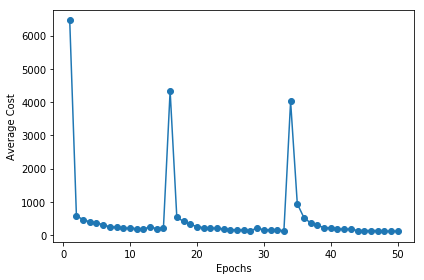

fitting ( 7 , 9 )...


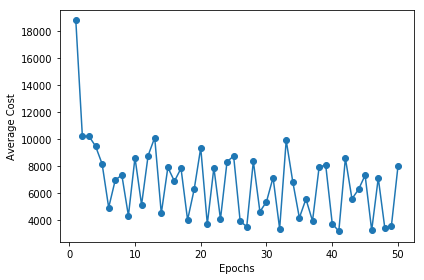

fitting ( 8 , 9 )...


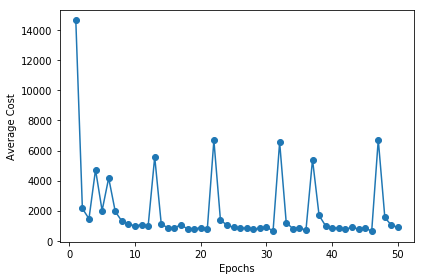

In [7]:
test.OvO(img,lbl)

In [12]:
from sklearn.metrics import accuracy_score

y_test_pred = test.voting(img_re.reshape(img_re.shape[0],784),3,7)
print('Accuracy: %.5f' % accuracy_score(lbl_re, y_test_pred))

Accuracy: 0.99161


In [16]:
bb = np.random.rand(60,10)
bb

array([[7.84199557e-01, 8.98891155e-01, 5.51858727e-02, 2.26644039e-01,
        5.67069765e-01, 5.75605748e-01, 5.57813904e-01, 8.82270033e-01,
        3.38798217e-01, 9.17696381e-01],
       [9.36307206e-01, 9.34630643e-02, 5.95840287e-01, 8.09868000e-01,
        6.43184624e-01, 6.92834092e-01, 4.86534675e-01, 9.05552758e-01,
        2.78321753e-01, 2.18569159e-01],
       [8.52532384e-01, 7.10671532e-01, 4.42524937e-01, 2.94035801e-01,
        3.76138325e-02, 4.07926572e-01, 5.21738977e-02, 2.98773158e-01,
        3.06227628e-01, 6.48369166e-01],
       [3.94532727e-01, 7.83035967e-01, 1.03433602e-02, 6.35395411e-01,
        1.23004725e-01, 5.58660328e-01, 6.49593492e-01, 3.03220896e-01,
        7.07998060e-02, 9.27565769e-01],
       [4.96924317e-01, 1.65367936e-01, 8.99195330e-01, 6.15655542e-02,
        5.35100393e-01, 7.17684557e-01, 8.96480876e-01, 9.90530454e-01,
        1.38759569e-01, 4.45781433e-01],
       [1.94889502e-01, 4.77411695e-01, 2.97143375e-01, 2.74668089e-01,
   

In [15]:
np.argmax(bb,axis=1)

array([2, 8, 8, 9, 1, 0, 2, 4, 2, 9, 0, 2, 6, 1, 1, 9, 6, 8, 5, 6, 9, 4,
       5, 0, 8, 7, 9, 0, 4, 7, 9, 5, 8, 2, 1, 2, 4, 1, 6, 1, 4, 6, 9, 2,
       7, 3, 0, 8, 8, 3, 0, 3, 3, 6, 0, 2, 7, 3, 0, 7], dtype=int64)